<a href="https://colab.research.google.com/github/storimaging/Notebooks/blob/main/Restoration/ULA_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unadjusted Langevin Algorithm for inverse problems in imaging

**Authors:**
* [Julie Delon](https://github.com/judelo)
* Lucía Bouza

## Reminder on ULA

Assume that we want to sample from a target distribution $\pi \propto e^{-U}$, with $U:\mathbb{R}^d\rightarrow \mathbb{R}$ a known potential.

To this aim, we propose to use the Unadjusted Langevin Algorithm (ULA), which belongs to the family of MCMC methods, and relies on an Euler discretization of the  Langevin stochastic differential equation associated with $\pi$. 
The algorithm update step reads [REF]
$$X_{k+1} = X_k - \delta \nabla U (X_k) +\sqrt{2\delta } Z_{k+1},$$
where $\delta$ is a step size and $(Z_k)$ a sequence of i.i.d. $d$-dimensional standard Gaussian random variables. 
It can be shown that $(X_k)$ is an homogeneous Markov chain.

Under some specific conditions on $U$ and $\delta$, it can be shown that the chain $(X_n)$ converges to its unique invariant distribution $\pi_{\delta}$, which is "close" to the target distribution $\pi \propto e^{-U}$ (the smaller $\delta$, the closer the distributions).

Mainly, the assumptions on $U$ and $\delta$ are 
1. $U:\mathbb{R}^d\rightarrow \mathbb{R}$ is continuously differentiable and  such that $\nabla U$ is $L$-Lipschitz, i.e. such that
$$\forall x,y,\;\; \|\nabla U(x) - \nabla U (y)\| \le L \|x-y\|.$$
2. $U$ is strongly convex oustide a ball $B(0,R)$, i.e. there exists $m$ such that
$$\forall x,y \text{ oustide }  B(0,R), \;\;  U(y) - U (x) \ge \langle\nabla U(x),y-x\rangle +\frac m 2 \|x-y\|^2.$$
3. $\delta \le \frac 1 L$.  

Observe that 1. implies that 
$$\forall x,y,\;\;  U(y) - U (x) \le   \langle \nabla U(x),y-x \rangle +\frac L 2 \|x-y\|^2.$$
Hence, 1. and 2. imply that the behaviour of $\pi$ outside $B(0,R)$ is not too far from a Gaussian.

## Importing packages

Below is a list of packages required in the notebook.

- `numpy`
- `matplotlib` (display of images and graphics)
-  `os` (interactions with the operating system)
- `time` (measure time)
- `tqdm` (shows progress)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from time import time
from tqdm import tqdm

To import the solutions, execute the following cell. If you are using a Windows system, comment the `os.system` line, download the file by hand, and place it in the same folder as the notebook.

In [2]:
#os.system("wget -nc https://raw.githubusercontent.com/storimaging/Notebooks/main/Restoration/Solutions/ULA.py")
#from ULA import *

## Helper functions

In the next cell we define some functions for displaying images. 

In [3]:
#@title

# Function to display two images
def printImages(a, b, title_a, title_b, size1, size2):

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(size1, size1))
    axes[0].set_title(title_a)
    axes[0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[0].axis('off')
    axes[1].set_title(title_b)
    axes[1].imshow(b,cmap='gray',vmin=0,vmax=1)
    axes[1].axis('off')
    fig.tight_layout()
    plt.show()

# Function to display six images
def print6Images(a, b, c, d, e, f, title_a, title_b, title_c, title_d, title_e, title_f, size1, size2):

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(size1, size1))
    axes[0][0].set_title(title_a)
    axes[0][0].imshow(a,cmap='gray',vmin=0,vmax=1)
    axes[0][0].axis('off')
    axes[0][1].set_title(title_b)
    axes[0][1].imshow(b,cmap='gray',vmin=0,vmax=1)
    axes[0][1].axis('off')
    axes[0][2].set_title(title_c)
    axes[0][2].imshow(c,cmap='gray')
    axes[0][2].axis('off')
    axes[1][0].set_title(title_d)
    axes[1][0].imshow(d,cmap='gray',vmin=0,vmax=1)
    axes[1][0].axis('off')
    axes[1][1].set_title(title_e)
    axes[1][1].imshow(e,cmap='gray',vmin=0,vmax=1)
    axes[1][1].axis('off')
    axes[1][2].set_title(title_f)
    axes[1][2].imshow(f,cmap='gray',vmin=0,vmax=1)
    axes[1][2].axis('off')
    fig.tight_layout()

## 1D experiment
In the following, we start by experimenting with ULA for sampling 1D distributions.
The conditions on ULA make it appropriate for distributions which are not too far from Gaussian distributions in practice.

1. Use ULA to sample the Gaussian distribution with standard deviation $\sigma=1$ and mean $\mu=0$, that has density $\frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}}$.
2. Starting from $X_0=0$ for instance, what is the distribution of $X_n$ after $n$ iterations of ULA?  Show that the asymptotic variance of the chain is $\frac 2 {2- \delta}$. What happens when $\delta=1$?

Write a function `Y = ULA_gauss(niter,delta,x0)` where *niter* is the number of iterations, *delta* is the parameter $\delta$ of ULA algorithm, and *x0* is the initialization. *Y* will be the sequence of samples through iterations Y=($X_0,...X_n$). 

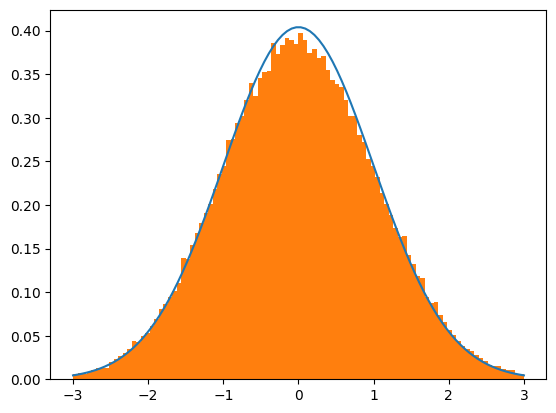

In [4]:
# Parametrers
x0 = 0
niter = int(1e5)
delta = .1

# Algorithm
Y = ULA_gauss(niter,delta,x0)

# Display gauss distribution (line in blue)
x = np.linspace(-3,3,100)  
y = 1/(np.sqrt(2*np.pi))*np.exp(-x**2 /2)
plt.plot(x,y/np.sum(y)*100/6)
# Display result of ULA sampling
plt.hist(Y,bins=100,range=[-3,3],density=1)
plt.show()

## Using ULA to sample TV-L2 with blur operator A 
We observe an image
$$u_b = Au_0+n$$
where the original image $u_0$ is unknown and the linear operator $A$ represents a (circular) convolution with a known kernel $h$, and $n$ represents i.i.d Gaussian noise. We wish to use ULA to sample from the distribution $\pi \propto e^{-U(u)}$ where
$$U(u) = \frac{1}{2\sigma^2}\|Au - u_b\|^2+ \lambda \mathrm{TV}(u). $$
If the blur operator $A$ is invertible (true for Gaussian blurs for instance), then the strong convexity assumption is valid. The TV term is not smooth, so we propose to use instead the Huber approximation of the total variation 
$$HTV(u) = \sum_{i\in \Omega} \|\nabla u(i)\|_\epsilon$$
where $$\|g\|_\epsilon = \begin{cases} \frac{\|g\|_2^2}{2\epsilon} & \text{ if } \|g\|_2 \le \epsilon \\ \|g\|_2 - \frac{\epsilon}{2} \text{ otherwise.}\end{cases}$$
$HTV(u)$ is smooth and its gradient is 
$$ \nabla HTV(u)_i = \begin{cases}  -\frac{1}{\epsilon} \mathrm{div} ({\nabla u_i})  & \text{ if } \|\nabla u_i\|_2 \le \epsilon \\  -\mathrm{div} \frac{\nabla u_i}{\|\nabla u_i\|_2}\text{ otherwise.}\end{cases}$$
If we use the simplest discrete scheme to compute the gradient, then $ \nabla HTV(u)$ is $\frac 8 \epsilon$ - Lipschitz for $\epsilon \le 1$. 


The ULA scheme can be written 
$$X_{k+1} = X_k - \frac{\delta}{\sigma^2}(A^* A X_k - A^* u_b) - \delta \lambda \nabla HTV(X_k) +\sqrt{2\delta } Z_{k+1}.$$






### 1. Create the blurry image. 

For the sake of simplicity we will use in the following a uniform blur, even if it does not fulfill the invertibility condition. The matrix $A$ is never computed explicitely (it would be HUGE !), all the operations involving $A$ or $A^*$ must be written directly in the Fourier domain. For instance:  
- If $Au$ is a convolution with the kernel $h$, it can be computed as 
$$\mathcal{F}^{-1} ( \hat{u}. \hat{h} )$$
with $\mathcal{F}$ the Fourier transform, $\hat{u}=\mathcal{F}(u)$, $\hat{h}=\mathcal{F}(h)$ and $\mathcal{F}^{-1}$ the inverse Fourier transform.
- $A^*u$ is a convolution with the conjugate of the kernel $h$.
- the inversion $(Id+\sigma AA^*)^{-1} u $ in the Fourier domain becomes a division  $\frac{\hat{u}}{1+ \sigma |\hat{h}|^2}$ 

Definition of convolution function and kernel.

In [5]:
def kernel(n_row, n_col, s):
   # kernel definition (for (2*s+1, 2*s+1) uniform kernel)
   h = np.zeros((n_row,n_col))
   h[0:2*s+1,0:2*s+1] = np.ones((2*s+1, 2*s+1))/(2*s+1)**2 
   return h

def convol_periodic(a,b):
   return np.real(np.fft.ifft2(np.fft.fft2(a)*np.fft.fft2(b))) 

We now import an image and create a blurred version with additive noise. 

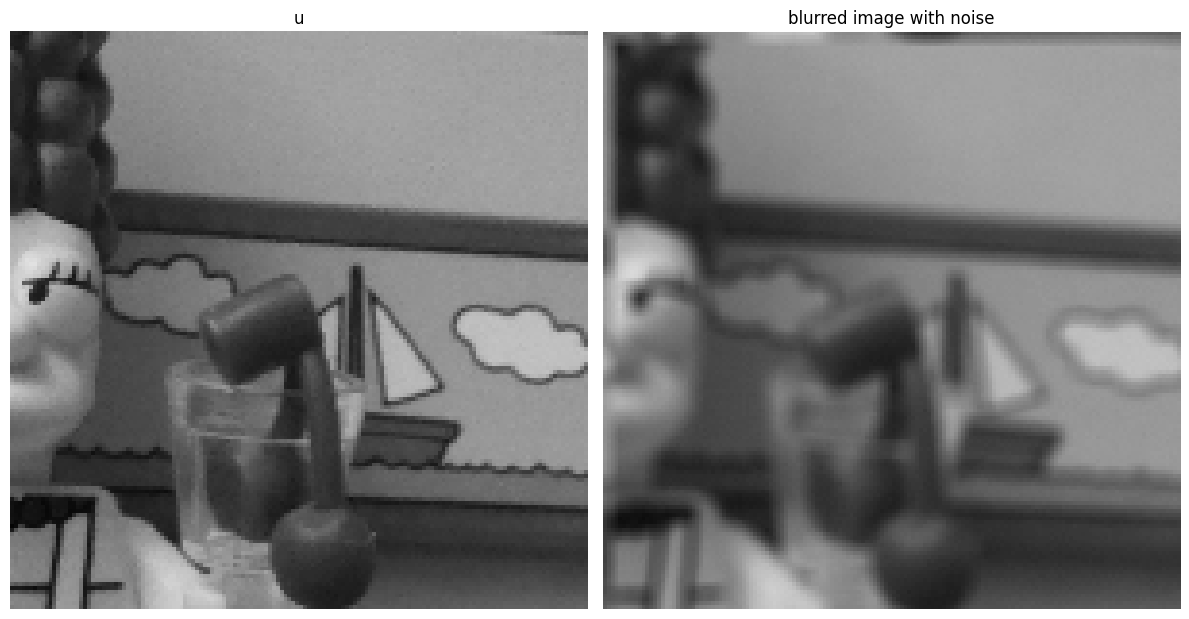

In [6]:
# Read image
os.system("wget -nc https://raw.githubusercontent.com/storimaging/Images/main/img/simpson_nb512.png")
u = plt.imread("simpson_nb512.png")

# Crop image
u = u[100:250,100:250]

# blurred image + noise
sigma = 1/255
h = kernel(u.shape[0], u.shape[1], 2)
ub = convol_periodic(u,h) + sigma*np.random.randn(u.shape[0],u.shape[1])

# Print images
printImages(u, ub, "u", "blurred image with noise", 12, 6)

### 2.ULA deblurring

In the next cell we  run the ULA algorithm. We also run the Chambolle-Pock TV-L2 algorithm for comparison purposes.

We compute the average value of all samples after a burn-in phase.

Write a function `ula_deblurring` with the following parameters:
- ub: noisy image
- u: original image (to compute output MMSE_error)
- sigma: standard deviation of noise of noisy image. 
- delta: parameter of ULA iteration
- lambd: TV regularization parameter lambda
- epsilon: Regularization for HTV (since ULA needs differentiable potentials) 
- h: kernel of convolution
- inter: interval between two saved samples
- n_iter: total number of iterations 
- n_burn_in: number of iterations for the burn-in phase. 

The algorithm returns:
- X_mean: The average posterior
- Xf: Last sample
- std: The posterior standard deviation
- X_samples: sequence of saved samples through iterations
- MMSE_error: Average error between X_mean and u

In [7]:
# Parameters for ULA
lambd = 30                
epsilon = .01  
L = 1/sigma**2 + 8*lambd/epsilon # Lipschitz constant        
delta = 1/L # step-size
inter = 10 # interval between samples that are kept in the file X_samples
n_iter = int(1e4)
n_burn_in = int(0.1*n_iter) 

# ULA algorithm (be patient, or use a small image)
t1 = time()
X_mean, Xf, std, X_samples, MMSE_error = ula_deblurring(ub, u, sigma, delta, lambd, epsilon, h, inter, n_iter, n_burn_in)
print("\nTime spent ULA: ",time()-t1)

# TV-MAP
t1 = time()
u_map = chambolle_pock_deblurring_TVL2(ub,h,sigma**2*lambd,niter=200)
print("Time spent Chambolle-Pock: ",time()-t1)

100%|██████████| 10000/10000 [01:18<00:00, 127.00it/s]



Time spent ULA:  78.76857471466064
Time spent Chambolle-Pock:  1.14784574508667


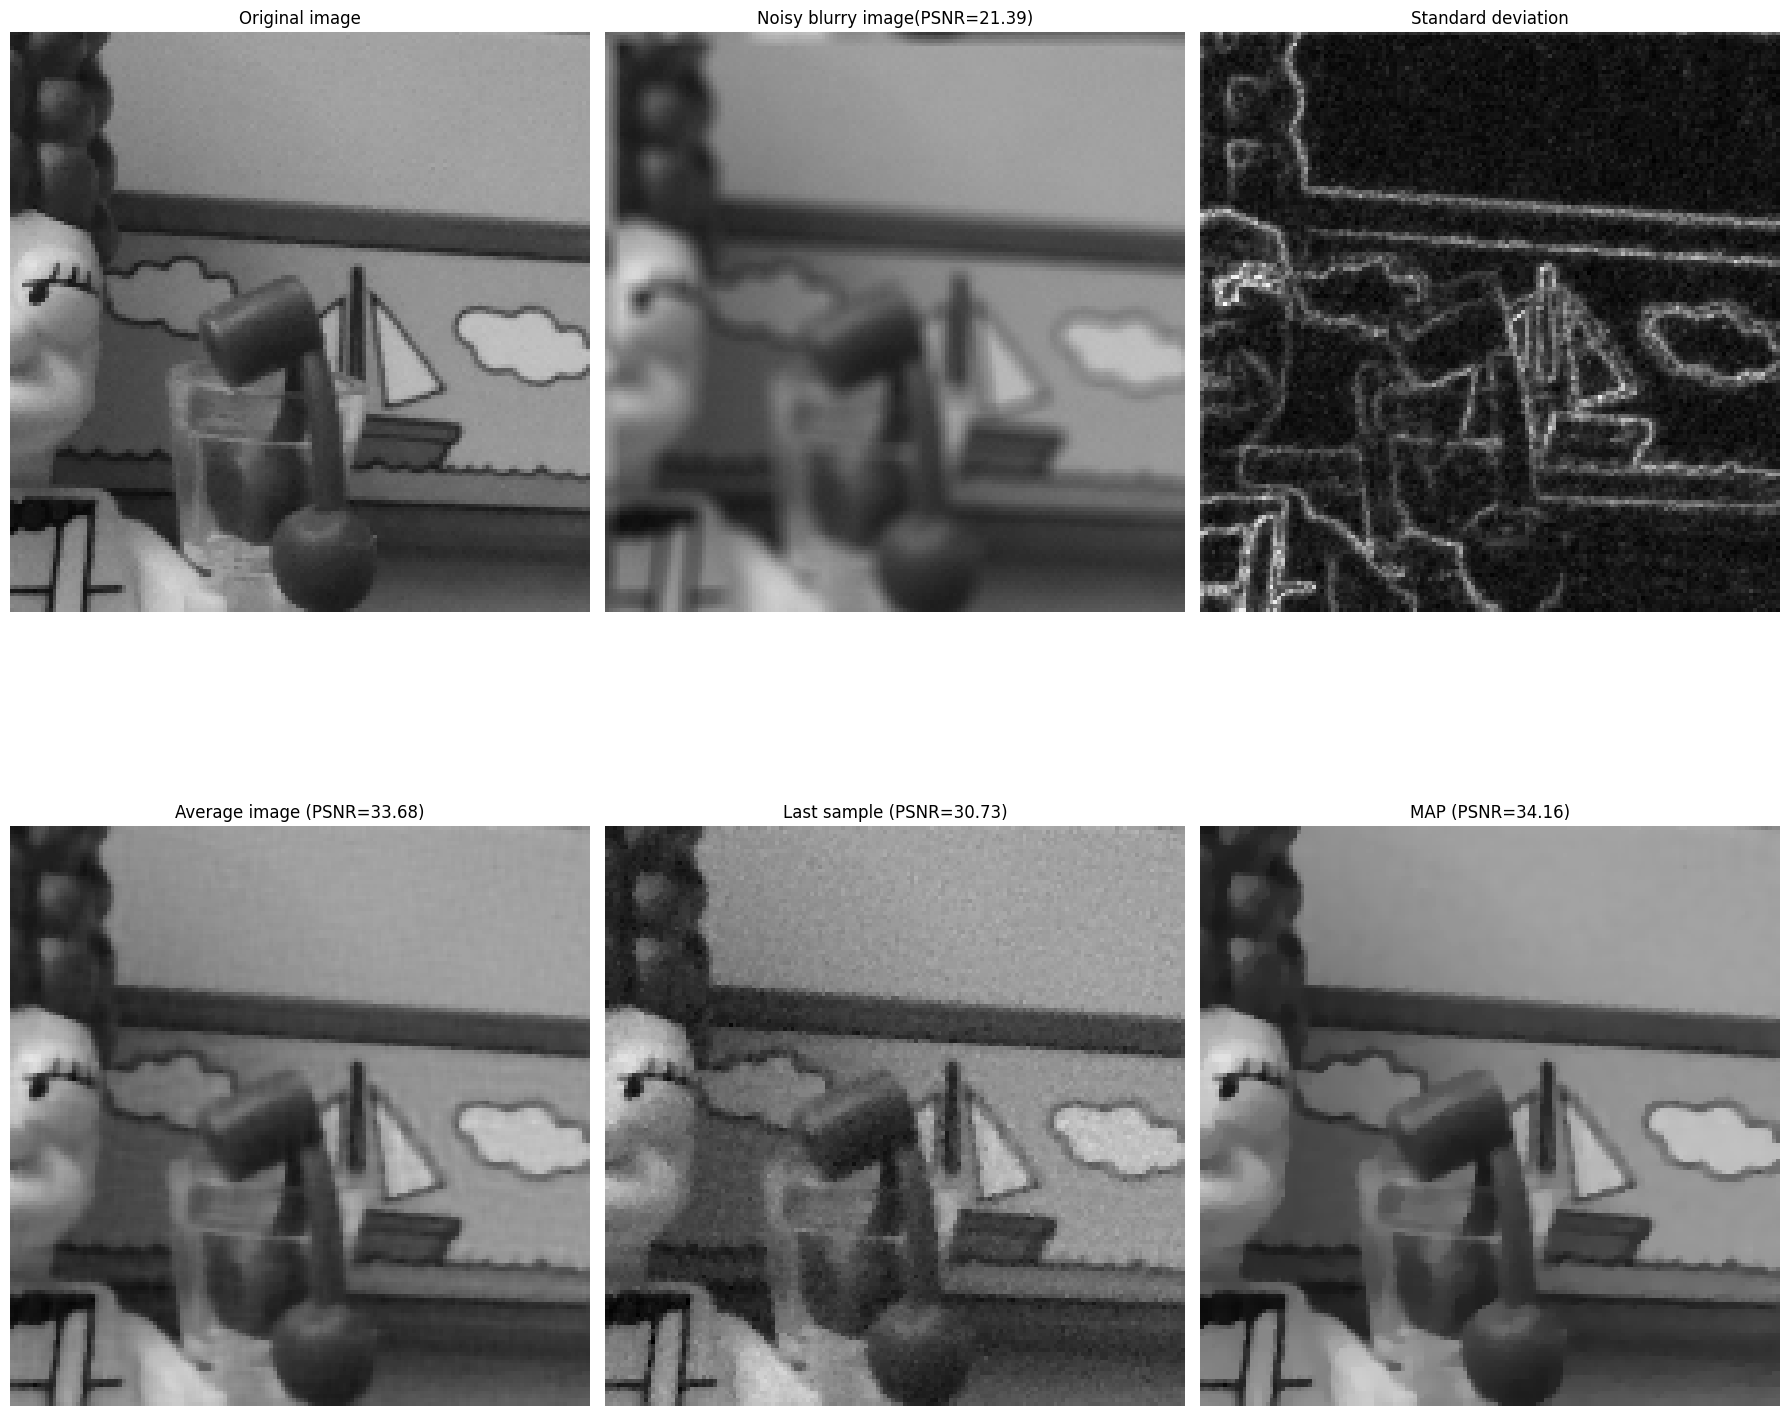

In [8]:
# Display results
print6Images(u, ub, std, X_mean, Xf, u_map, \
             'Original image', \
             'Noisy blurry image(PSNR={:.2f})'.format(PSNR(u, ub)), \
             'Standard deviation', \
             'Average image (PSNR={:.2f})'.format(PSNR(u, X_mean)), \
             'Last sample (PSNR={:.2f})'.format(PSNR(u, Xf)), \
             'MAP (PSNR={:.2f})'.format(PSNR(u, u_map)), \
             18, 18)

We display below the error between the empirical mean and the original image $u$, as well as the error between the individual samples and $u$.

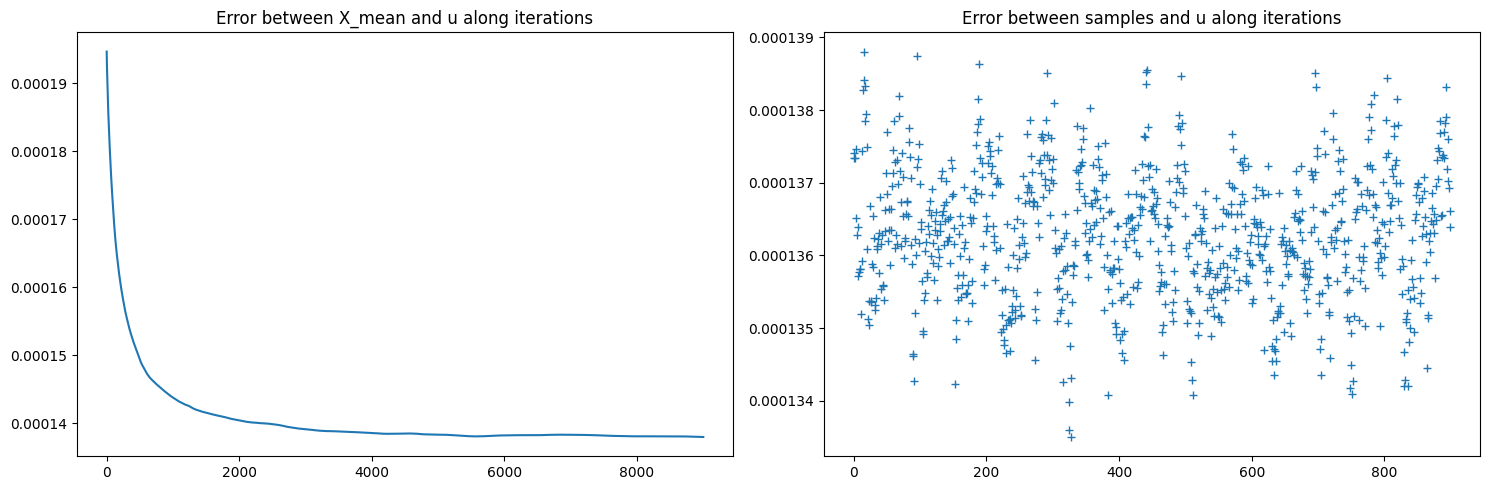

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
axes[0].set_title('Error between X_mean and u along iterations')
axes[0].plot(MMSE_error)
axes[1].set_title('Error between samples and u along iterations')
axes[1].plot(1/(u.shape[0]*u.shape[1])*np.sqrt(np.sum(np.sum((X_samples[:,:,int(X_samples.shape[2]/10):] - X_mean[:,:,np.newaxis])**2,0),0)),'+')
fig.tight_layout()
plt.show()